In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from scipy.special import expit

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

/Users/sjack/Library/Caches/pypoetry/virtualenvs/pymc-notebooks-xRFgMF1w-py3.10/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
moons = make_moons(n_samples=500,random_state=RANDOM_SEED, noise=0.1)
x1p=(moons[0][:, 0])
x2p=(moons[0][:, 1])
yp = moons[1]

In [3]:
x1p.mean()

0.5090725193911988

<AxesSubplot:>

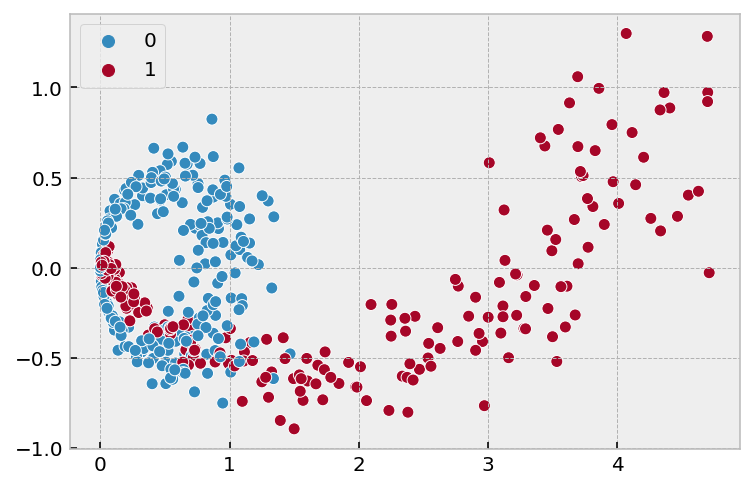

In [47]:
sns.scatterplot(x=x1p**2, y=np.multiply(x2p,x1p), hue=moons[1])

In [5]:
with pm.Model() as model:
    # Data
    x1 = pm.MutableData(name="x1", value = (moons[0][:,0]) )
    x2 = pm.MutableData(name="x2", value = (moons[0][:,1]) )
    x3 = pm.MutableData(name="x3", value = (moons[0][:,0]) ** 2 )
    x4 = pm.MutableData(name="x4", value = (moons[0][:,1]) ** 2 )
    x5 = pm.MutableData(name="x5", value = (moons[0][:,0]) ** 3 )
    x6 = pm.MutableData(name="x6", value = (moons[0][:,1]) ** 3 )
    y = pm.MutableData(name="y", value = moons[1])
    #priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    beta3 = pm.Normal("beta3", mu=0, sigma=1)
    beta4 = pm.Normal("beta4", mu=0, sigma=1)
    beta5 = pm.Normal("beta5", mu=0, sigma=1)
    beta6 = pm.Normal("beta6", mu=0, sigma=1)
    beta7 = pm.Normal("beta7", mu=0, sigma=1)
    #likelihood
    likelihood = pm.invlogit(beta0 + (beta1 * x1) + (beta2 * x2) + (beta3 * x3) + (beta4 * x4) + (beta5 * x5) + (beta6 * x6) )
    #outcome
    logit = pm.Bernoulli("logit", p=likelihood, observed=y)


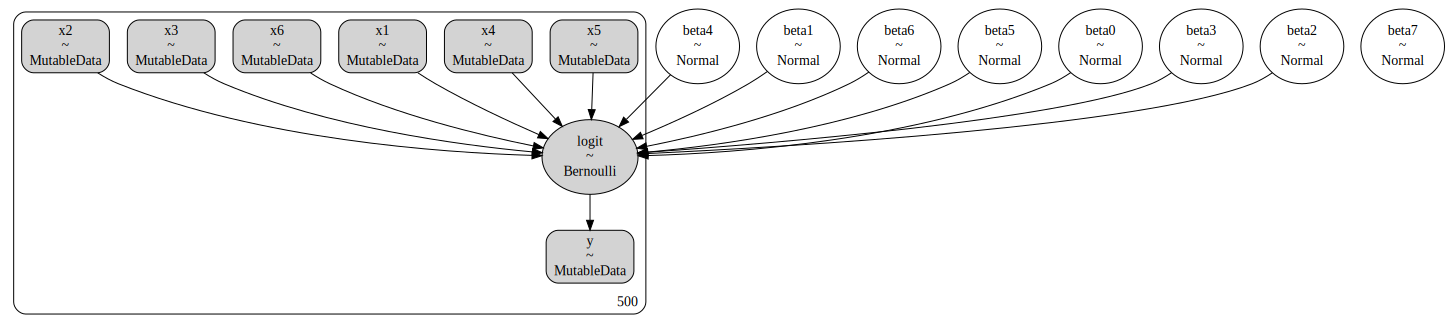

In [6]:
pm.model_to_graphviz(model)

In [7]:
with model:
    priors = pm.sample_prior_predictive()

In [8]:
priors

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [9]:
with model:
    trace = pm.sample(6000, chains=4, cores=-1, target_accept=0.95)


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc:Sequential sampling (4 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, beta5, beta6, beta7]
INFO:pymc:NUTS: [beta0, beta1, beta2, beta3, beta4, beta5, beta6, beta7]


Sampling 4 chains for 1_000 tune and 6_000 draw iterations (4_000 + 24_000 draws total) took 72 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 6_000 draw iterations (4_000 + 24_000 draws total) took 72 seconds.


array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'beta3'}>,
        <AxesSubplot:title={'center':'beta3'}>],
       [<AxesSubplot:title={'center':'beta4'}>,
        <AxesSubplot:title={'center':'beta4'}>],
       [<AxesSubplot:title={'center':'beta5'}>,
        <AxesSubplot:title={'center':'beta5'}>],
       [<AxesSubplot:title={'center':'beta6'}>,
        <AxesSubplot:title={'center':'beta6'}>],
       [<AxesSubplot:title={'center':'beta7'}>,
        <AxesSubplot:title={'center':'beta7'}>]], dtype=object)

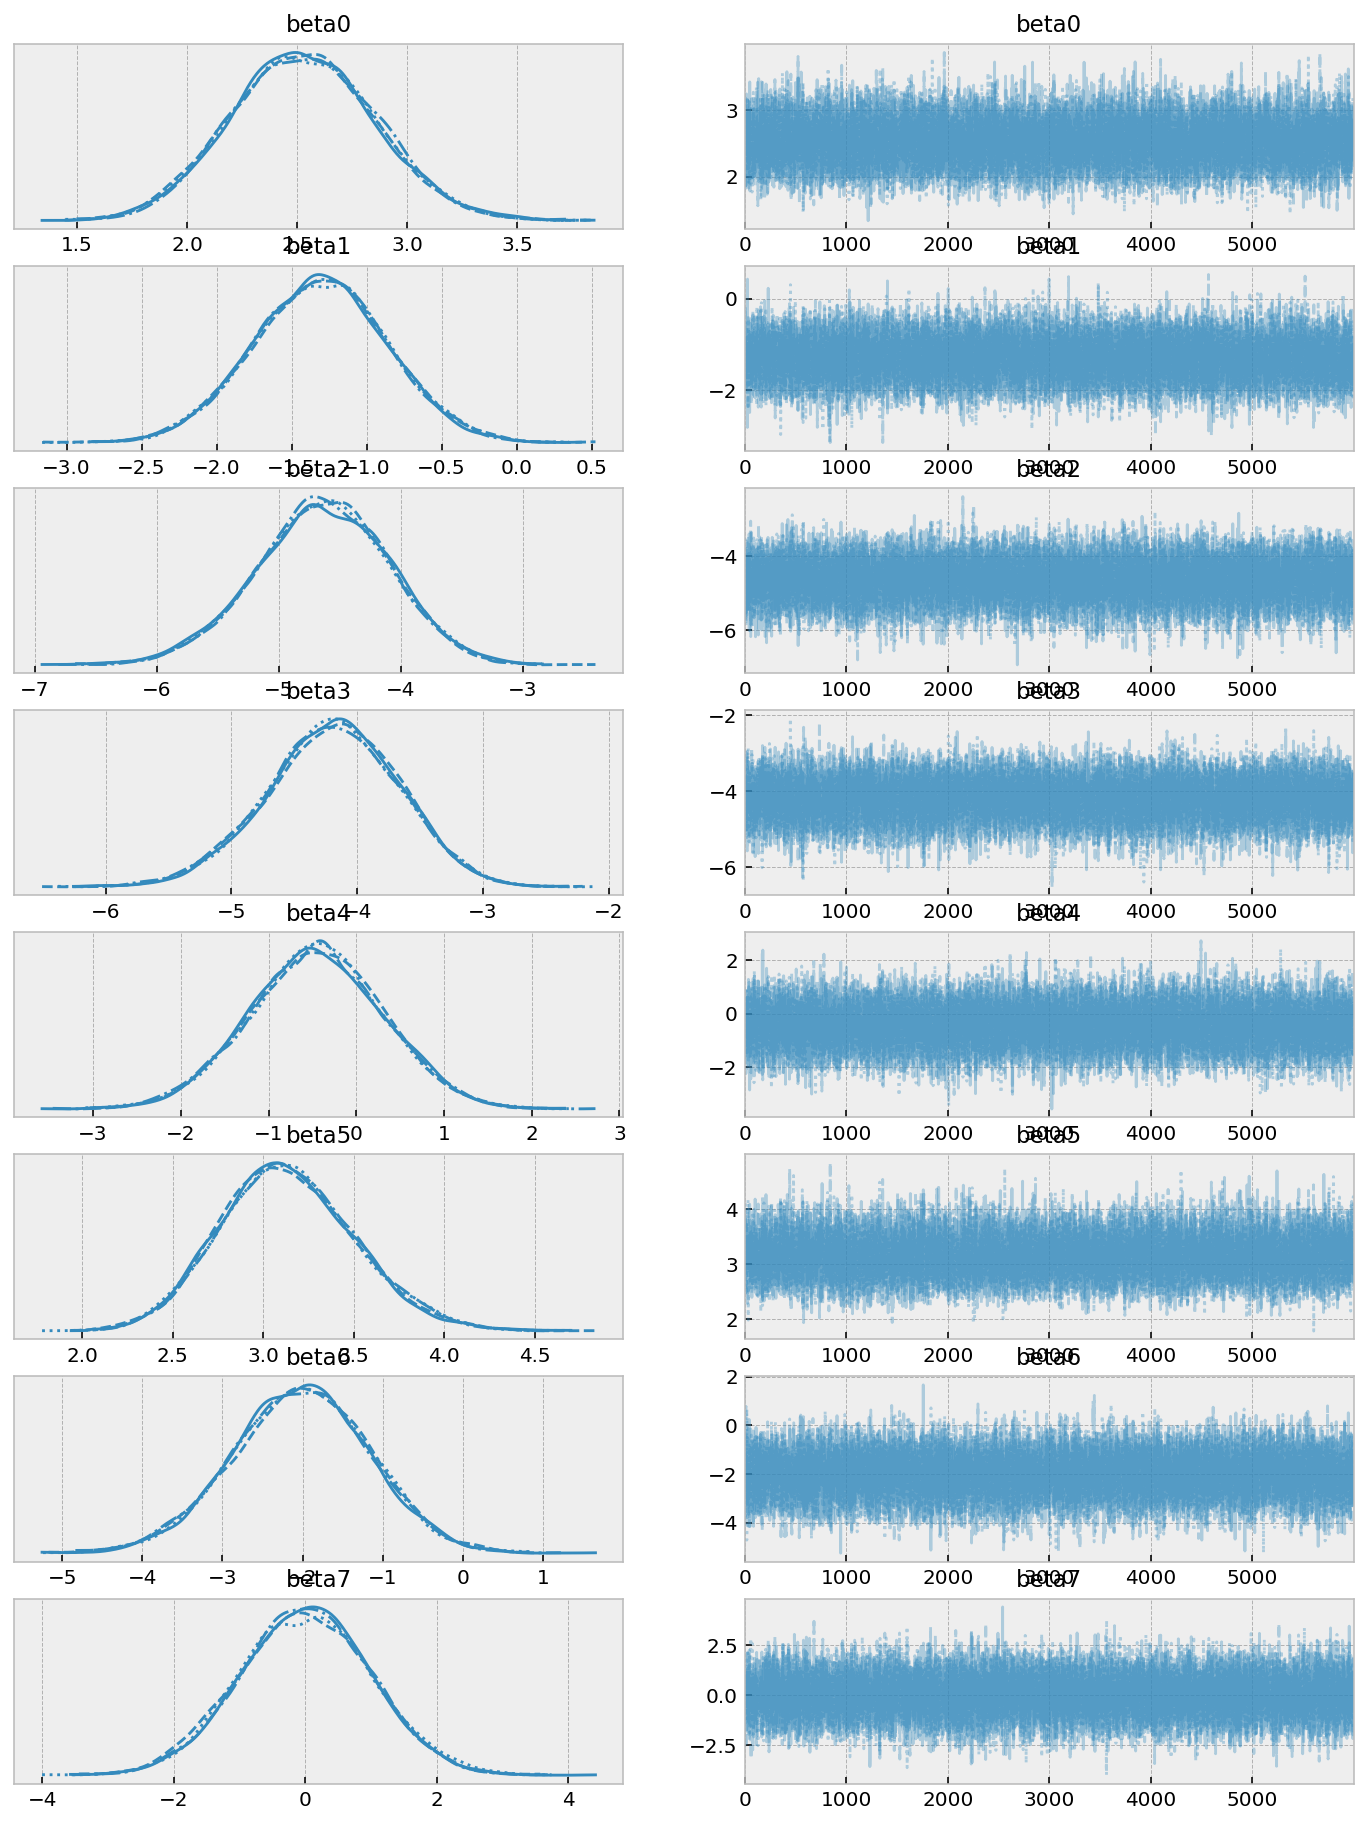

In [10]:
pm.plot_trace(trace)

In [11]:
with model:
    posterior = pm.sample_posterior_predictive(trace)

In [36]:
predictions = posterior.posterior_predictive.logit.mean(axis=0).mean(axis=0)

In [37]:
miss = (predictions.round() != moons[1])
predictions_correct = 1 - miss.mean()
print(predictions_correct)

<xarray.DataArray 'logit' ()>
array(0.982)


In [38]:
predictions = np.round(predictions.values * 10) / 10

In [39]:
ddata = pd.DataFrame({"x1": x1p, "x2": x2p, "y": yp, "likelihood": predictions})

In [40]:
beta0mean = trace.posterior.beta0.mean().values
beta1mean = trace.posterior.beta1.mean().values
beta2mean = trace.posterior.beta2.mean().values
beta3mean = trace.posterior.beta3.mean().values
beta4mean = trace.posterior.beta4.mean().values
beta5mean = trace.posterior.beta5.mean().values
beta6mean = trace.posterior.beta6.mean().values
beta7mean = trace.posterior.beta7.mean().values

In [41]:
xx =   np.linspace(-2, 1.5, 100)

In [42]:
decision_bound = expit(beta0mean + (beta1mean * xx) + (beta2mean * xx) + (beta3mean * xx ** 2) + (beta4mean * xx ** 2) + (beta5mean * xx ** 3 )+ (beta6mean * xx ** 3) + (beta7mean * xx ** 2 * xx ** 2))

<AxesSubplot:xlabel='x1', ylabel='x2'>

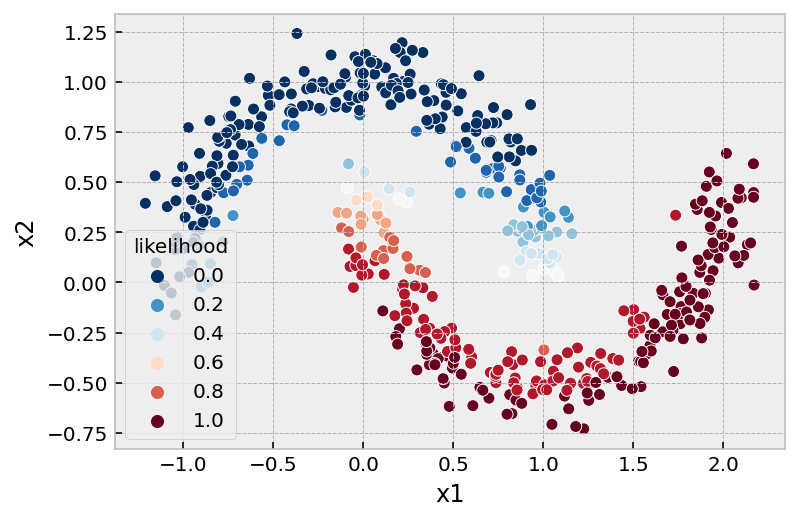

In [43]:
sns.scatterplot(data=ddata, x="x1", y="x2", hue="likelihood", palette="RdBu_r")

In [20]:
sns

<module 'seaborn' from '/Users/sjack/Library/Caches/pypoetry/virtualenvs/pymc-notebooks-xRFgMF1w-py3.10/lib/python3.10/site-packages/seaborn/__init__.py'>